This notebook repeats the example from `01_Optimizing_RandomForest_using_DEHB` but without using `ConfigSpace` for the parameter space, or the search space definition.

***

In [1]:
import time
import numpy as np
import warnings


seed = 123
np.random.seed(seed)
warnings.filterwarnings('ignore')

The hyperparameters chosen, along with their *type*, and *ranges*:
* `max_depth` $-$ *integer* $-$ [1, 15]
* `min_samples_split` $-$ *integer* $-$ [2, 128] $-$ *log*-spacing
* `max_features` $-$ *float* $-$ [0.1, 0.9]
* `min_samples_leaf` $-$ *integer* $-$ [1, 64] $-$ *log*-spacing 

DE, and therefore DEHB, work in the unit hypercube space. The random individuals sampled at the beginning of DEHB, performs a uniform random sampling in the [0, 1] range for each parameter/dimension. Hence, each configuration suggested by DEHB also is in the [0, 1] range. The `vector_to_configspace` included in the DEHB source code, can reliably handle the transformation of the [0, 1] space of DEHB configurations to the original parameter space required. **In the absence of ConfigSpace usage, such a conversion needs to included as part of the objective/target function being passed.**

### Defining transformation from DEHB [0,1]-space to original parameter space

In [2]:
# Declaring the search space
param_space = {
    "max_depth": [1, 15, int, False],
    "min_samples_split": [2, 128, int, True],
    "max_features": [0.1, 0.9, float, False],
    "min_samples_leaf": [1, 64, int, True],
}
dimensions = len(param_space)

# Declaring the fidelity range
min_budget, max_budget = 2, 50


def transform_space(param_space, configuration):
    """ Scales the [0, 1]-ranged parameter linearly to [lower, upper]
    
    Parameters
    ----------
    param_space : a dict containing the parameters and their meta-info
    configuration : a vector with each dimension in [0, 1] (from DEHB)
    
    Results
    -------
    a dict which can be passed to the model as named hyperparameters
    """
    assert len(configuration) == len(param_space)
    config_dict = dict()
    for i, (k, v) in enumerate(param_space.items()):
        value = configuration[i]
        lower, upper = v[0], v[1]
        is_log = v[3]
        if is_log:
            # performs linear scaling in the log-space
            log_range = np.log(upper) - np.log(lower)
            value = np.exp(np.log(lower) + log_range * value)
        else:
            # linear scaling within the range of the parameter
            value = lower + (upper - lower) * value
        if v[2] == int:
            value = np.round(value).astype(int)
        config_dict[k] = value
    return config_dict    

**NOTE**: To handle categorical parameters would require custom representations for such cases. Categorical parameters don't have a lower or upper range but rather a possible list of discrete choices or values. Moreoever, categorical parameters can be string categories, boolean or even ordinal in nature.


Given this `transform_space` function, everything else from `01_Optimizing_RandomForest_using_DEHB` can be largely reused. Only the `target_function` needs to be modified to include the `transform_space` function. Also, the `configspace` parameter needs to be set tp `False` while initializing DEHB.

### Defining the target_function

In [3]:
from sklearn.datasets import load_digits, load_wine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer


accuracy_scorer = make_scorer(accuracy_score)


def prepare_dataset(model_type="classification"):

    if model_type == "classification":
        dataset = np.random.choice(list(classification.keys()))
        _data = classification[dataset]()
    else:
        dataset = np.random.choice(list(regression.keys()))
        _data = regression[dataset]()

    train_X, test_X, train_y, test_y = train_test_split(
        _data.get("data"), 
        _data.get("target"), 
        test_size=0.1, 
        shuffle=True, 
        random_state=seed
    )
    train_X, valid_X, train_y, valid_y = train_test_split(
        _data.get("data"), 
        _data.get("target"), 
        test_size=0.3, 
        shuffle=True, 
        random_state=seed
    )
    return train_X, train_y, valid_X, valid_y, test_X, test_y, dataset


def target_function(config, budget, **kwargs):
    # Extracting support information
    seed = kwargs["seed"]
    train_X = kwargs["train_X"]
    train_y = kwargs["train_y"]
    valid_X = kwargs["valid_X"]
    valid_y = kwargs["valid_y"]
    max_budget = kwargs["max_budget"]
    
    # Mapping [0, 1]-vector to Sklearn parameters
    param_space = kwargs["param_space"]
    config = transform_space(param_space, config)
    
    if budget is None:
        budget = max_budget
    
    start = time.time()
    # Building model 
    model = RandomForestClassifier(
        **config,
        n_estimators=int(budget),
        bootstrap=True,
        random_state=seed,
    )
    # Training the model on the complete training set
    model.fit(train_X, train_y)
    
    # Evaluating the model on the validation set
    valid_accuracy = accuracy_scorer(model, valid_X, valid_y)
    cost = time.time() - start
    
    # Evaluating the model on the test set as additional info
    test_accuracy = accuracy_scorer(model, test_X, test_y)
    
    result = {
        "fitness": -valid_accuracy,  # DE/DEHB minimizes
        "cost": cost,
        "info": {
            "test_score": test_accuracy,
            "budget": budget
        }
    }
    return result


classification = {"digits": load_digits, "wine": load_wine}
train_X, train_y, valid_X, valid_y, test_X, test_y, dataset = \
    prepare_dataset(model_type="classification")

print(dataset)
print("Train size: {}\nValid size: {}\nTest size: {}".format(
    train_X.shape, valid_X.shape, test_X.shape
))

digits
Train size: (1257, 64)
Valid size: (540, 64)
Test size: (180, 64)


### Running DEHB

In [4]:
from dehb import DEHB


dehb = DEHB(
    f=target_function, 
    dimensions=dimensions, 
    min_budget=min_budget, 
    max_budget=max_budget,
    n_workers=1,
    output_path="./temp"
)

In [5]:
trajectory, runtime, history = dehb.run(
    total_cost=10, 
    verbose=False,
    save_intermediate=False,
    seed=123,
    train_X=train_X,
    train_y=train_y,
    valid_X=valid_X,
    valid_y=valid_y,
    max_budget=dehb.max_budget,
    param_space=param_space
)

In [6]:
print("Incumbent score: {}".format(dehb.inc_score))
print("Incumbent configuration:\n{}".format(transform_space(param_space, dehb.inc_config)))

Incumbent score: -0.9685185185185186
Incumbent configuration:
{'max_depth': 10, 'min_samples_split': 3, 'max_features': 0.24012458257841524, 'min_samples_leaf': 2}


##### Evaluating the incumbent

In [7]:
model = RandomForestClassifier(
    **transform_space(param_space, dehb.inc_config),
    n_estimators=int(max_budget),
    bootstrap=True,
    random_state=seed,
)
model.fit(
    np.concatenate((train_X, valid_X)),
    np.concatenate((train_y, valid_y))
)
test_accuracy = accuracy_scorer(model, test_X, test_y)
print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 1.0


##### Plotting the optimization trace with the update of incumbents over time

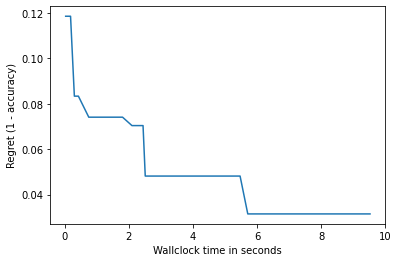

In [8]:
from matplotlib import pyplot as plt

plt.plot(np.cumsum(runtime), np.array(trajectory) + 1)
plt.xlabel("Wallclock time in seconds")
plt.ylabel("Regret (1 - accuracy)");